# Import

In [16]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
from scipy.stats import mode
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import optuna
from optuna.samplers import TPESampler
import glob

# About Dataset
- Sample Rate = 25Hz
- Duration = 20 mins
- AF = 19 respondent
- Non-AF = 16 respondent
- n_data per pasien = 25Hz * (20m * 60s) = 30000 data per pasien
- Total data = 30000 * 35 pasien = 1050000. Tapi detik ke-0 juga diitung jadi = 1050035

## Path

In [17]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir,'..','..'))
af_folder = os.path.join(project_root, 'Data', 'af')
print(af_folder)
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

af_files = sorted(glob.glob(os.path.join(af_folder, '*.csv')))[:19]
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*.csv')))[:16]

c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\af


## Train Test Split

In [18]:
test_af = af_files[:3]        
val_af = af_files[3:6]        
train_af = af_files[6:]       

test_nonaf = nonaf_files[:3]  
val_nonaf = nonaf_files[3:6]  
train_nonaf = nonaf_files[6:] 

## Load Dataset

In [19]:
def load(files, status):
    arr = []
    for f in files:
        df = pd.read_csv(f)
        if len(df) > 150000:
            df = df.iloc[:150000]
        df['status'] = status
        arr.append(df)
    return arr

test_af_data = load(test_af, 1)
val_af_data = load(val_af, 1)
train_af_data = load(train_af, 1)

test_nonaf_data = load(test_nonaf, 0)
val_nonaf_data = load(val_nonaf, 0)
train_nonaf_data = load(train_nonaf, 0)

test = pd.concat(test_af_data + test_nonaf_data, ignore_index=True)
val = pd.concat(val_af_data + val_nonaf_data, ignore_index=True)
train = pd.concat(train_af_data + train_nonaf_data, ignore_index=True)
df = pd.concat([train, val, test], ignore_index=True)

df

,Time,PPG,ECG,status,resp
0,0.000,0.529412,0.732283,1,NaN
1,0.008,0.521569,0.748031,1,NaN
2,0.016,0.513725,0.740157,1,NaN
3,0.024,0.501961,0.748031,1,NaN
4,0.032,0.494118,0.748031,1,NaN
...,...,...,...,...,...
5249995,1199.960,0.442815,-0.131373,0,0.448954
5249996,1199.968,0.434018,-0.141176,0,0.450185
5249997,1199.976,0.426197,-0.131373,0,0.450185
5249998,1199.984,0.418377,-0.141176,0,0.450185


# EDA

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450000 entries, 0 to 3449999
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Time    float64
 1   PPG     float64
 2   ECG     float64
 3   status  int64  
 4   resp    float64
dtypes: float64(4), int64(1)
memory usage: 131.6 MB


In [21]:
train.describe()

,Time,PPG,ECG,status,resp
count,3.450000e+06,3.447873e+06,3.449761e+06,3.450000e+06,2.550000e+06
mean,5.999960e+02,1.028791e+00,4.417415e-01,5.652174e-01,2.541229e-01
std,3.464102e+02,7.644235e-01,2.391073e-01,4.957285e-01,4.128840e-01
min,0.000000e+00,0.000000e+00,-5.019608e-01,0.000000e+00,-1.846506e+00
25%,2.999980e+02,4.193548e-01,3.125000e-01,0.000000e+00,2.912621e-03
50%,5.999960e+02,5.757576e-01,4.394531e-01,1.000000e+00,2.325922e-01
75%,8.999940e+02,1.810362e+00,5.551758e-01,1.000000e+00,4.613881e-01
max,1.199992e+03,4.001955e+00,1.503922e+00,1.000000e+00,2.844215e+00


In [22]:
status_count = train['status'].value_counts()
status_count

status
1    1950000
0    1500000
Name: count, dtype: int64

## Pie chart AF Status

In [23]:
# Pie chart (for percentage)
status = status_count.sort_index()
status_index = status.index
fig = px.pie(names=status_index, values=status, hole=0.3,
             labels={'names':'status'}, title='AF Status Distribution Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [24]:
train.isna().sum()

Time           0
PPG         2127
ECG          239
status         0
resp      900000
dtype: int64

In [25]:
train.isna().mean() * 100

Time       0.000000
PPG        0.061652
ECG        0.006928
status     0.000000
resp      26.086957
dtype: float64

## Visualize signal on specific range

In [26]:
def show_wave_from(df, pasien_ke=1, s_start=0, s_stop=10, fitur='ppg', af_status=0, sample_rate=125):
    lama_ukur = 1200 # 20m = 1200s
    sample_per_pasien = lama_ukur * sample_rate
    duration = s_stop - s_start

    if 0 <= s_start <= lama_ukur and 0 <= s_stop <= lama_ukur:
        if af_status == 0 and 1 <= pasien_ke <= 16:
            afdf = df[df['status'] == 0]
        elif af_status == 1 and 1 <= pasien_ke <= 19:
            afdf = df[df['status'] == 1]
        else:
            print('Invalid nomor pasien atau sample time')

        dfpasien = afdf[(pasien_ke - 1) * sample_per_pasien : pasien_ke * sample_per_pasien]
        dfintvl = dfpasien[sample_rate*s_start : (sample_rate*s_stop)+1]
            
        x_ax = dfintvl['Time']
        y_ax = dfintvl[fitur]

        plt.figure(figsize=(16, 4))
        plt.plot(x_ax, y_ax)
        plt.title(f'Gelombang {fitur} dari pasien ke-{pasien_ke} dari {s_start} - {s_stop} detik')

        step = s_start
        for t in range(duration):
            step += 1
            plt.axvline(x=step, color='gray', linestyle='--', linewidth=0.8)

        plt.show()

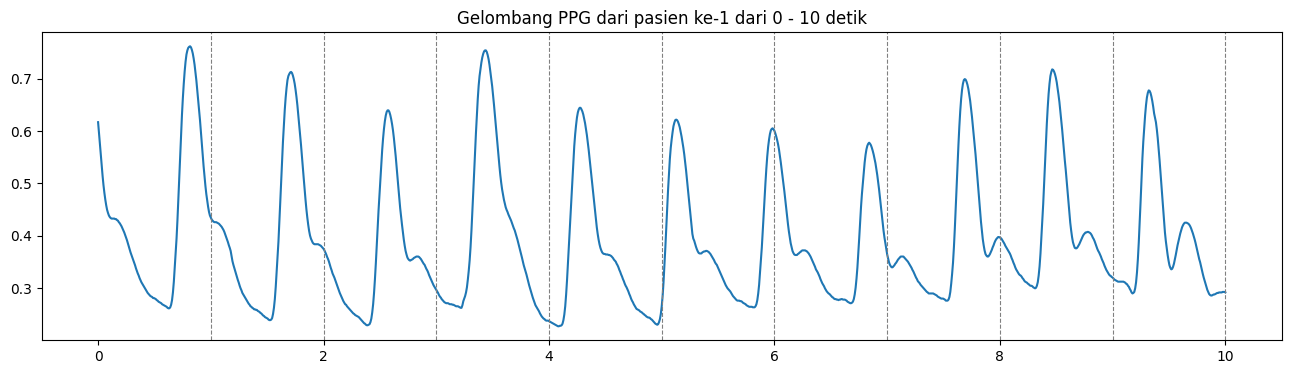

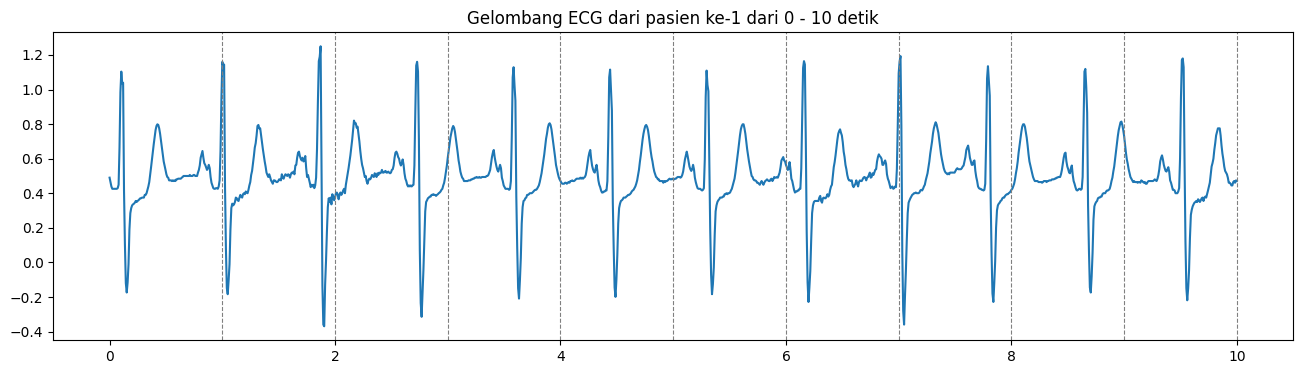

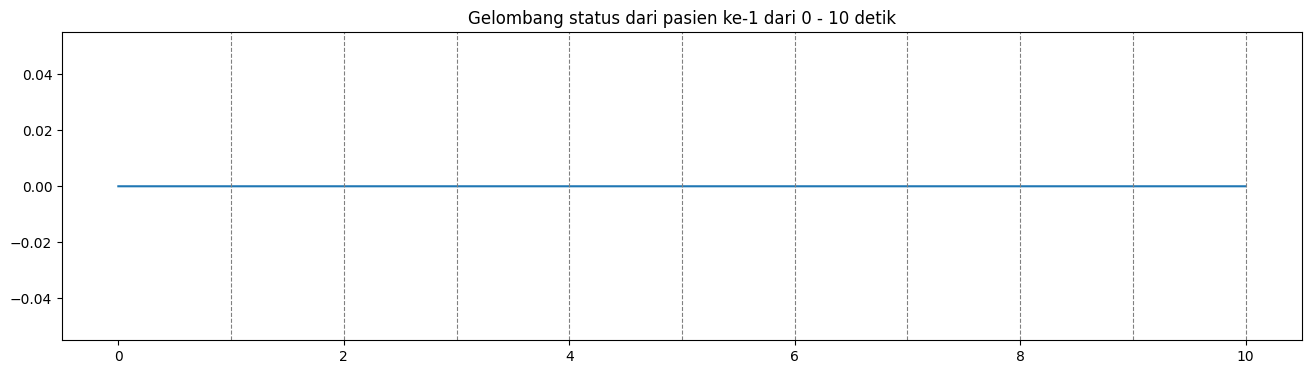

In [27]:
for i in df.columns[1:-1]:
    show_wave_from(df, fitur=i, sample_rate=125)

## AF VS Non-AF Wave

Non-AF Wave:

Feature: PPG


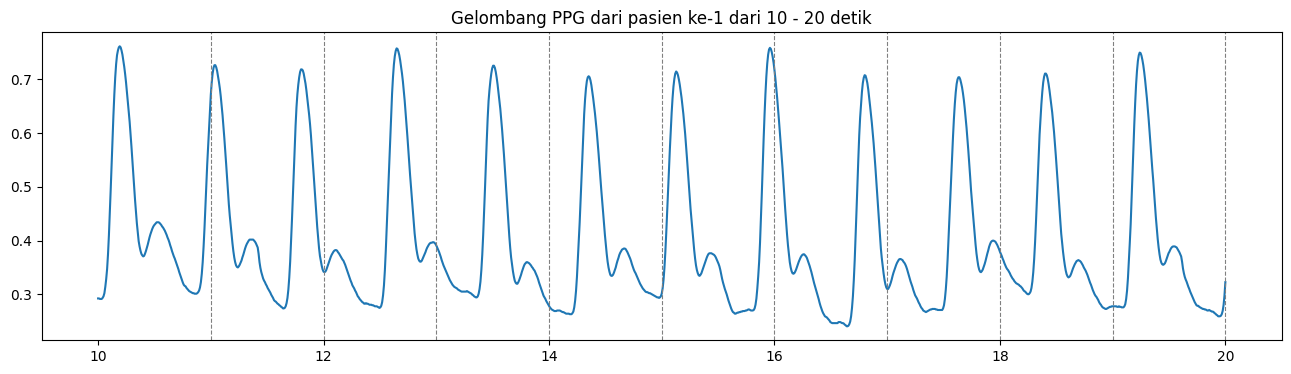


Feature: ECG


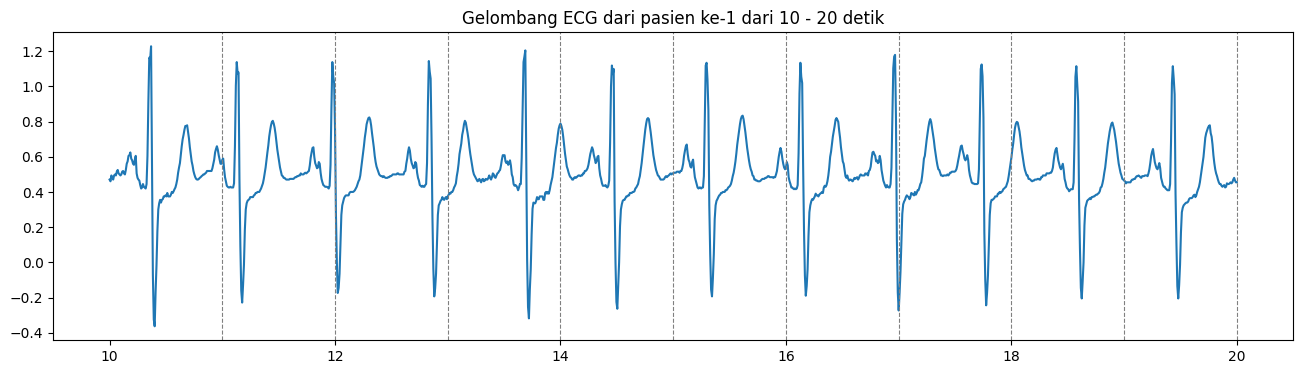


Feature: status


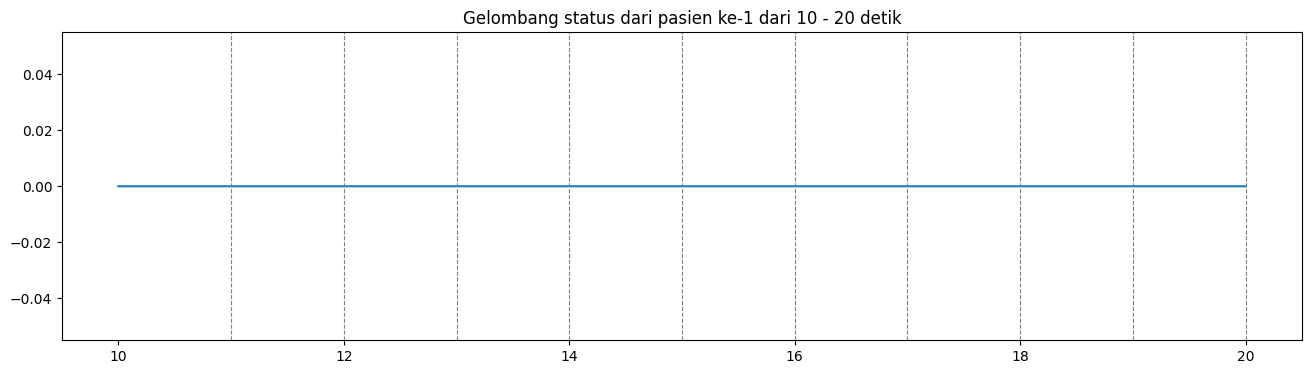


AF Wave:

Feature: PPG


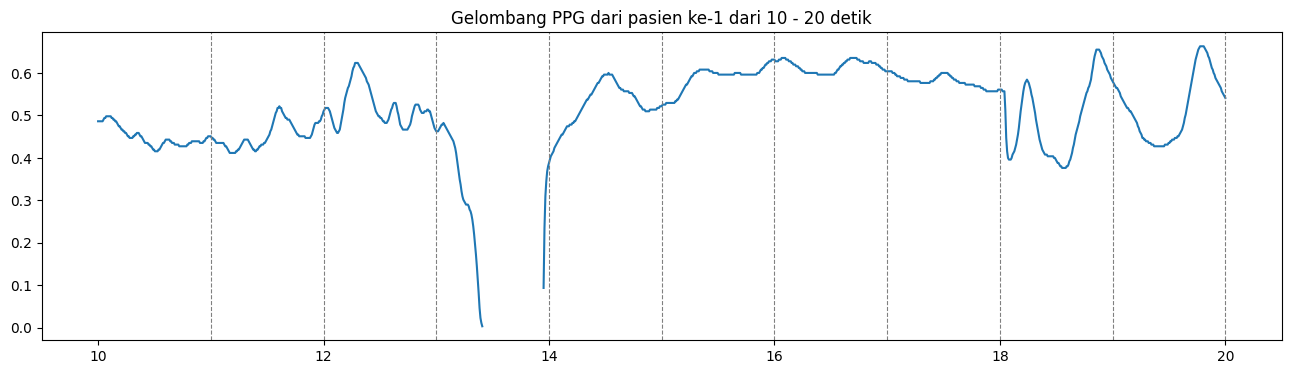


Feature: ECG


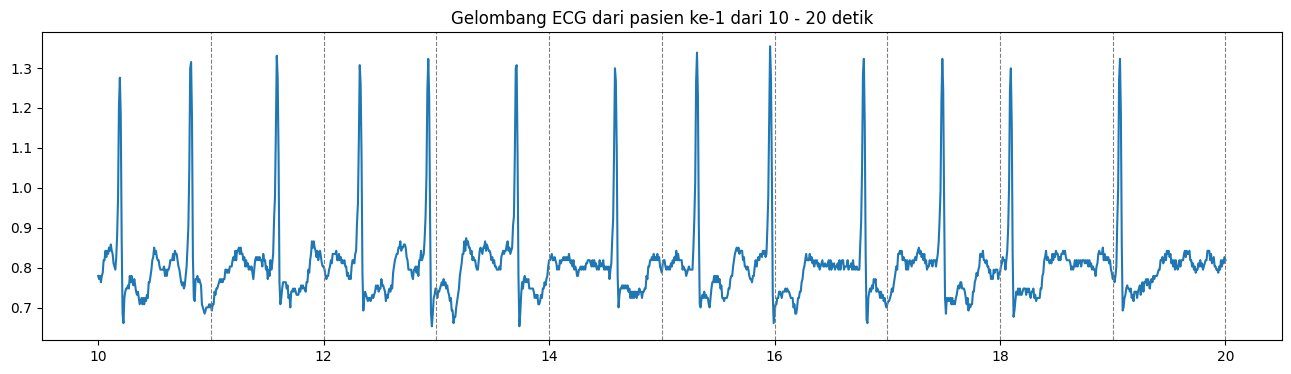


Feature: status


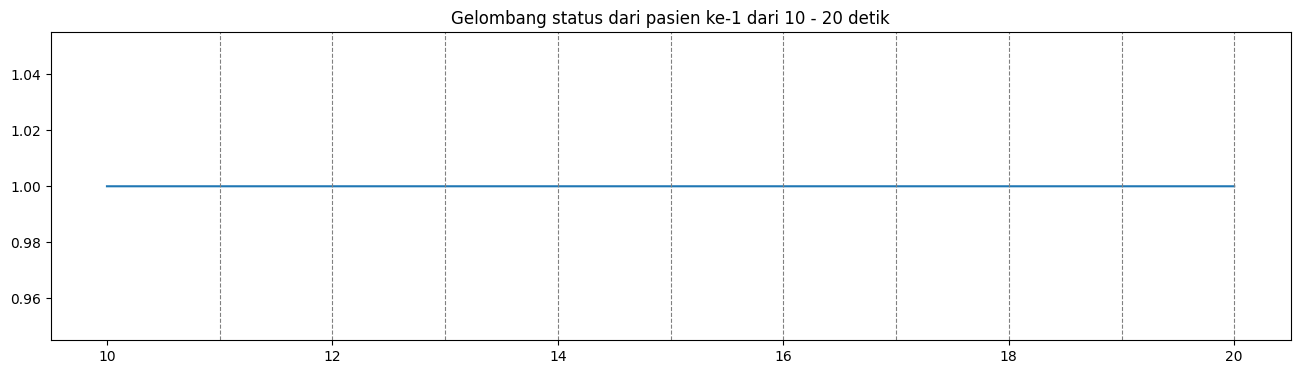

In [28]:
# Check data resp untuk pasien yang dipilih
print('Non-AF Wave:')
for i in df.columns[1:-1]:
    print(f'\nFeature: {i}')
    # Ambil data pasien pertama non-AF
    nonaf_df = df[df['status'] == 0]
    pasien_data = nonaf_df[1250:2500]  # 10-20 detik
    
    # Cek apakah ada variasi di data resp
    if i == 'resp':
        print(f"  Min: {pasien_data[i].min()}")
        print(f"  Max: {pasien_data[i].max()}")
        print(f"  Std: {pasien_data[i].std()}")
        print(f"  Unique values: {pasien_data[i].nunique()}")
    
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=0, fitur=i)

print('\n' + '='*50)
print('AF Wave:')
for i in df.columns[1:-1]:
    print(f'\nFeature: {i}')
    # Ambil data pasien pertama AF
    af_df = df[df['status'] == 1]
    pasien_data = af_df[1250:2500]  # 10-20 detik
    
    # Cek apakah ada variasi di data resp
    if i == 'resp':
        print(f"  Min: {pasien_data[i].min()}")
        print(f"  Max: {pasien_data[i].max()}")
        print(f"  Std: {pasien_data[i].std()}")
        print(f"  Unique values: {pasien_data[i].nunique()}")
    
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=1, fitur=i)

# Praprocessing

## Imputation: Interpolation

### Train

In [29]:
train['PPG'] = train['PPG'].interpolate()
train['ECG'] = train['ECG'].interpolate()
train['resp'] = train['resp'].interpolate(limit_direction='both')
train.isna().sum()

Time      0
PPG       0
ECG       0
status    0
resp      0
dtype: int64

### Test

In [30]:
test['PPG'] = test['PPG'].interpolate()
test['ECG'] = test['ECG'].interpolate()
test['resp'] = test['resp'].interpolate()
test.isna().sum()

Time      0
PPG       0
ECG       0
resp      0
status    0
dtype: int64

### Validation

In [31]:
val['PPG'] = val['PPG'].interpolate()
val['ECG'] = val['ECG'].interpolate()
val['resp'] = val['resp'].interpolate()
val.isna().sum()


Time      0
PPG       0
ECG       0
resp      0
status    0
dtype: int64

## Set Window Size

In [32]:
sampling_rate = 125
window_size = sampling_rate    # 125 segment per window
n_features = 3  # PPG, ECG, and RESP

def create_windows(data):
    """Create windows from signal data"""
    ppg_signal = data['PPG'].values
    ecg_signal = data['ECG'].values
    resp_signal = data['resp'].values
    n_windows = len(ppg_signal) // window_size
    
    windows_list = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        ppg_window = ppg_signal[start:end]
        ecg_window = ecg_signal[start:end]
        resp_window = resp_signal[start:end]
        # Stack PPG, ECG, and RESP as separate features
        combined_window = np.column_stack([ppg_window, ecg_window, resp_window])
        windows_list.append(combined_window)
    
    # Convert to array: shape will be (n_windows, 125, 3)
    windows_array = np.array(windows_list)
    print(f"Windows shape: {windows_array.shape}")
    
    # Flatten for DataFrame storage: each row = 375 values (125*3)
    df_window = pd.DataFrame(windows_array.reshape(n_windows, -1))
    return df_window, n_windows

# Create windows for train and test separately
df_window_train, n_windows_train = create_windows(train)
df_window_test, n_windows_test = create_windows(test)
df_window_val, n_windows_val = create_windows(val)

print(f"\nTrain windows: {n_windows_train}")
print(f"Test windows: {n_windows_test}")
print(f"Validation windows: {n_windows_val}")

# Use combined df_window for compatibility with cells below
df_window = pd.concat([df_window_train, df_window_test, df_window_val], ignore_index=True)
n_windows = n_windows_train + n_windows_test + n_windows_val

print(f"\nTotal windows: {n_windows}")
df_window


Windows shape: (27600, 125, 3)
Windows shape: (7200, 125, 3)
Windows shape: (7200, 125, 3)

Train windows: 27600
Test windows: 7200
Validation windows: 7200

Total windows: 42000


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,0.529412,0.732283,-0.769759,0.521569,0.748031,-0.769759,0.513725,0.740157,-0.769759,0.501961,...,-0.769759,0.494118,0.818898,-0.769759,0.490196,0.842520,-0.769759,0.482353,0.842520,-0.769759
1,0.474510,0.850394,-0.769759,0.466667,0.842520,-0.769759,0.458824,0.850394,-0.769759,0.450980,...,-0.769759,0.572549,0.795276,-0.769759,0.564706,0.803150,-0.769759,0.552941,0.795276,-0.769759
2,0.545098,0.795276,-0.769759,0.537255,0.787402,-0.769759,0.529412,0.795276,-0.769759,0.525490,...,-0.769759,0.509804,0.811024,-0.769759,0.513725,0.818898,-0.769759,0.517647,0.803150,-0.769759
3,0.517647,0.795276,-0.769759,0.517647,0.795276,-0.769759,0.517647,0.795276,-0.769759,0.517647,...,-0.769759,0.611765,0.803150,-0.769759,0.619608,0.818898,-0.769759,0.627451,0.818898,-0.769759
4,0.635294,0.818898,-0.769759,0.639216,0.803150,-0.769759,0.643137,0.818898,-0.769759,0.643137,...,-0.769759,0.627451,1.157480,-0.769759,0.639216,0.858268,-0.769759,0.647059,0.661417,-0.769759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.261975,0.119608,0.094819,0.261975,0.133333,0.090909,0.262952,0.158824,0.086999,0.264907,...,0.536657,0.626588,-0.060784,0.539589,0.608993,-0.182353,0.542522,0.589443,-0.217647,0.544477
41996,0.570870,-0.217647,0.546432,0.553275,-0.217647,0.548387,0.536657,-0.207843,0.550342,0.520039,...,1.000000,0.223851,0.094118,1.000000,0.221896,0.098039,1.000000,0.219941,0.088235,1.000000
41997,0.218964,0.094118,1.000000,0.217986,0.088235,1.000000,0.217009,0.094118,1.000000,0.214076,...,0.247312,0.697947,0.500000,0.238514,0.713587,0.570588,0.230694,0.727273,0.705882,0.222874
41998,0.735093,0.760784,0.215054,0.740958,0.866667,0.206256,0.744868,0.982353,0.198436,0.746823,...,0.000000,0.374389,-0.176471,0.000000,0.370479,-0.127451,0.000000,0.365591,-0.060784,0.000000


In [33]:
# jml kolom
len(df_window.iloc[0,:])

375

### Visualisasi

In [34]:
# Visualize one window from df_window
window_idx = 0  # Select which window to visualize
window_data = df_window_train.iloc[window_idx].values.reshape(125, 3)

# Create time array for x-axis
time_array = np.arange(125) / sampling_rate

### PPG

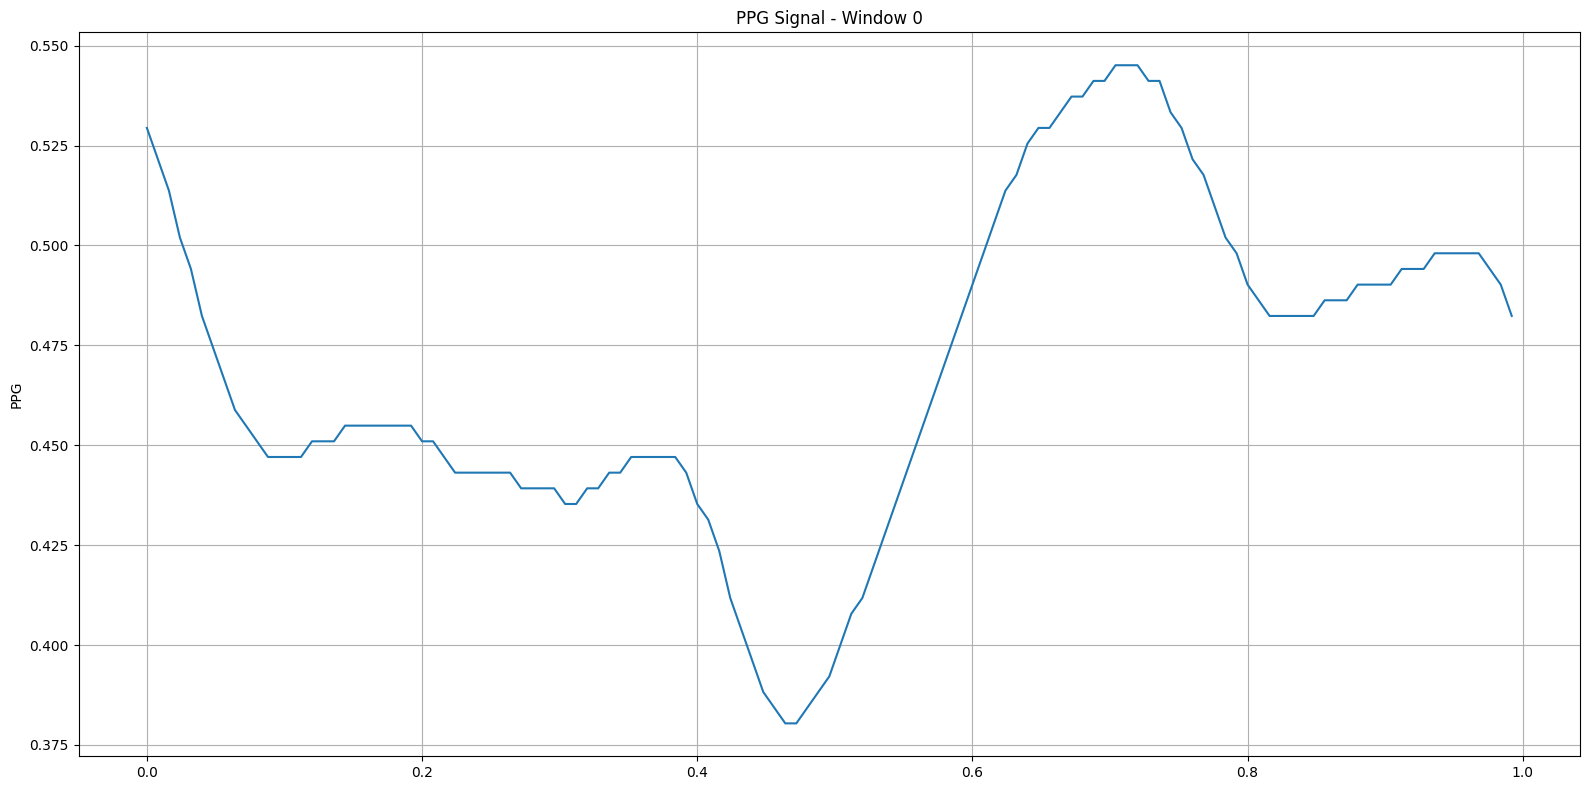

In [35]:
# Plot the three signals
plt.figure(figsize=(16, 8))

plt.plot(time_array, window_data[:, 0])
plt.title(f'PPG Signal - Window {window_idx}')
plt.ylabel('PPG')
plt.grid(True)

plt.tight_layout()
plt.show()

### ECG

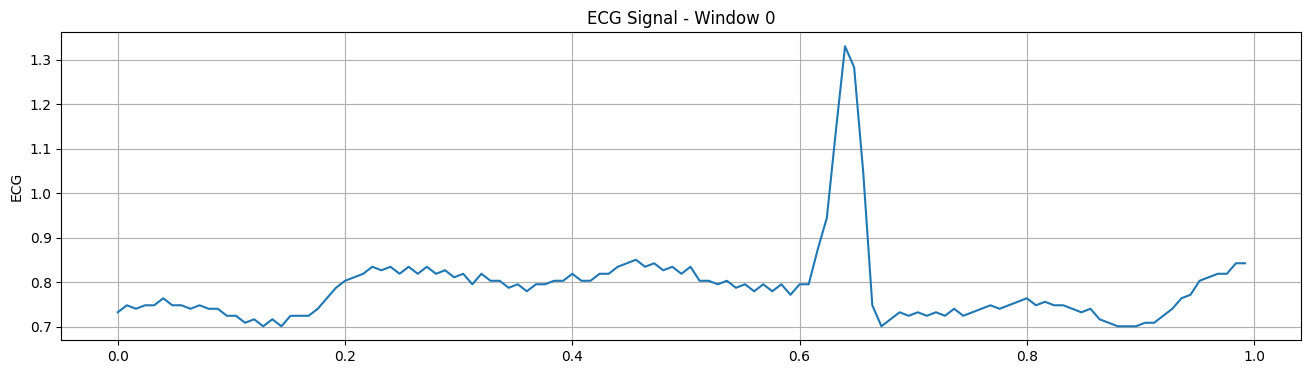

In [36]:
plt.figure(figsize=(16, 4))
plt.plot(time_array, window_data[:, 1])
plt.title(f'ECG Signal - Window {window_idx}')
plt.ylabel('ECG')
plt.grid(True)
plt.show()

### RESP

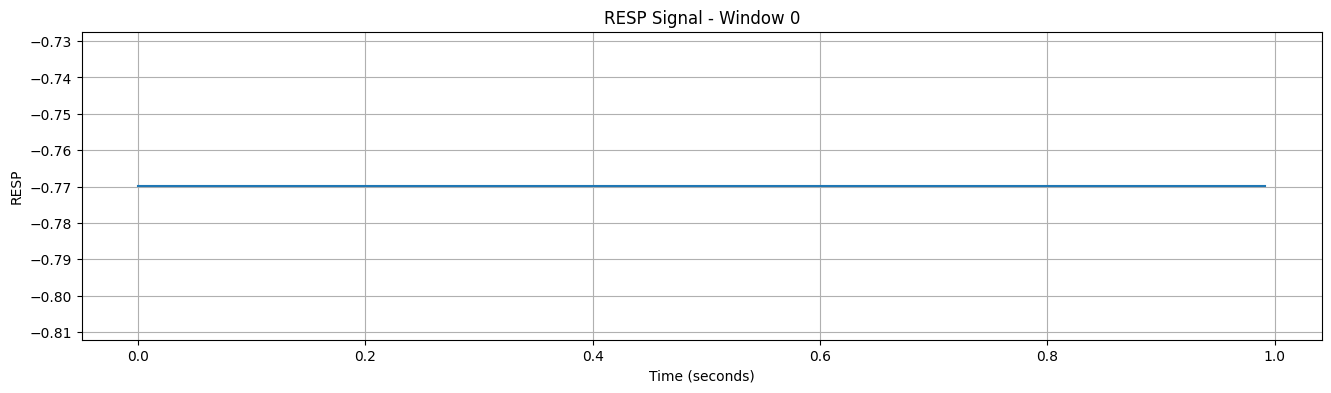

In [37]:
plt.figure(figsize=(16, 4))
plt.plot(time_array, window_data[:, 2])
plt.title(f'RESP Signal - Window {window_idx}')
plt.ylabel('RESP')
plt.xlabel('Time (seconds)')
plt.grid(True)
plt.show()

## Add Label

In [38]:
train_status = train['status'].values
test_status = test['status'].values
val_status = val['status'].values

train_labels = []
for i in range(n_windows_train):
    start = i * window_size
    end = start + window_size
    window_status = train_status[start:end]
    label = mode(window_status, keepdims=False).mode
    train_labels.append(label)

test_labels = []
for i in range(n_windows_test):
    start = i * window_size
    end = start + window_size
    window_status = test_status[start:end]
    label = mode(window_status, keepdims=False).mode
    test_labels.append(label)

val_labels = []
for i in range(n_windows_val):
    start = i * window_size
    end = start + window_size
    window_status = val_status[start:end]
    label = mode(window_status, keepdims=False).mode
    val_labels.append(label)

df_label_train = pd.Series(train_labels)
df_label_test = pd.Series(test_labels)
df_label_val = pd.Series(val_labels)


df_label = pd.concat([df_label_train, df_label_test, df_label_val], ignore_index=True)

print(f"Train labels: {len(df_label_train)}")
print(f"Test labels: {len(df_label_test)}")
print(f"Validation Labels: {len(df_label_val)}")
print(f"Total labels: {len(df_label)}")
df_label

Train labels: 27600
Test labels: 7200
Validation Labels: 7200
Total labels: 42000


0        1
1        1
2        1
3        1
4        1
        ..
41995    0
41996    0
41997    0
41998    0
41999    0
Length: 42000, dtype: int64

## Preprocess Pipeline

In [39]:
# Reshape data to 3D format (n_samples, 125, 3)
# Data now has 375 columns (125 timesteps * 3 features: PPG, ECG, RESP)
X_train_prep = df_window_train.values.reshape(-1, 125, 3)
X_val_prep = df_window_val.values.reshape(-1, 125, 3)
X_test_prep = df_window_test.values.reshape(-1, 125, 3)

print(f"X_train shape: {X_train_prep.shape}")
print(f"X_val shape: {X_val_prep.shape}")
print(f"X_test shape: {X_test_prep.shape}")
print(f"\n✅ Data contains PPG, ECG, and RESP (3 features)")

X_train shape: (27600, 125, 3)
X_val shape: (7200, 125, 3)
X_test shape: (7200, 125, 3)

✅ Data contains PPG, ECG, and RESP (3 features)


In [40]:
# Transformer buat reshape 2D jadi 3D (updated for 3 features)
class ReshapeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_timesteps=125, n_features=3):
        self.n_timesteps = n_timesteps
        self.n_features = n_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # reshape jadi 3D: (n_samples, n_timesteps, n_features)
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.reshape(X, (X.shape[0], self.n_timesteps, self.n_features))

In [41]:
X_train_prep.shape

(27600, 125, 3)

# Ekstraksi Fitur

## LSTM Model untuk Ekstraksi Fitur

In [42]:
def build_model(n_timesteps=125, n_features=3):
    """Build LSTM model for PPG, ECG, and RESP signals"""
    model = Sequential([
        Input(shape=(n_timesteps, n_features)),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'])
    return model

In [43]:
# Train LSTM model
model = build_model(n_timesteps=125, n_features=3)
tf.compat.v1.enable_eager_execution()
history = model.fit(
    X_train_prep, df_label_train,
    epochs=60, # 60
    batch_size=64,
    validation_data=(X_val_prep, df_label_val),
    verbose=1
)
print(f"Training completed. Final val_loss: {history.history['val_loss'][-1]:.4f}")


Epoch 1/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.7464 - loss: 0.5007 - recall: 0.7522 - val_accuracy: 0.1883 - val_loss: 1.8492 - val_recall: 0.3711
Epoch 2/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7786 - loss: 0.4344 - recall: 0.7470 - val_accuracy: 0.3296 - val_loss: 1.9403 - val_recall: 0.6022
Epoch 3/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7917 - loss: 0.3954 - recall: 0.7562 - val_accuracy: 0.1947 - val_loss: 3.1910 - val_recall: 0.3383
Epoch 4/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.7633 - loss: 0.4631 - recall: 0.7585 - val_accuracy: 0.2890 - val_loss: 3.4585 - val_recall: 0.5614
Epoch 5/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7818 - loss: 0.4259 - recall: 0.7741 - val_accuracy: 0.2589 - val_loss: 1.6589 - val_recall: 0.4756
Epoch 6/60
432/432 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.7291 - loss: 0.5205 - recall: 0.8233 - val_accuracy: 0.2650 - val_loss: 2.8024 - val_recall

KeyboardInterrupt: 

### Save Model

In [ ]:
# Save trained LSTM model
os.makedirs('models/SVM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/SVM/lstm_ppg_ecg_resp_{timestamp}.h5'
model.save(model_path)
print(f'LSTM model saved as: {model_path}')

LSTM model saved as: models/lstm_ppg_ecg_resp_03122025_192437.h5


### Load Model

In [ ]:
# # Load saved LSTM model
# model_path = r"models\SVM\lstm_ppg_ecg_resp_04122025_105107.h5"
# model = load_model(model_path)
# print(f'✅ LSTM model loaded from: {model_path}')
# print(f'Model summary:')
# model.summary()

## Visualisasi Hasil

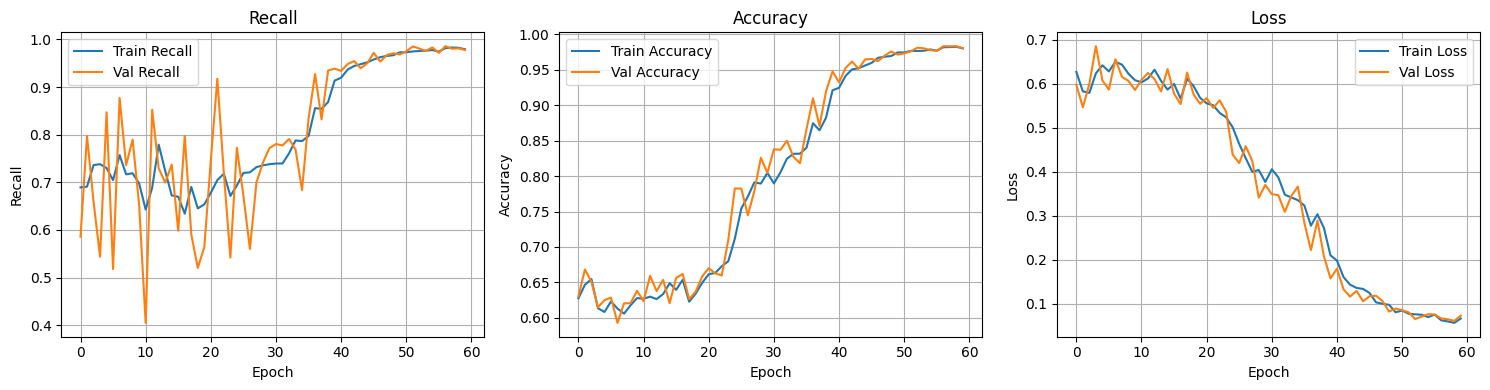

In [ ]:
# Plot training history
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Build Feature Extractor dari LSTM yang sudah dilatih
# Menggunakan output dari last dense layer (Dense 32) sebagai fitur
lstm_last_dense = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print("✅ LSTM Feature Extractor created")
lstm_last_dense.summary()

✅ LSTM Feature Extractor created


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,488 (76.12 KB)

 Trainable params: 19,488 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

## Ekstraksi Fitur dari LSTM

In [ ]:
# Extract features menggunakan LSTM feature extractor
# Output: 32 fitur dari last dense layer untuk setiap sampel
X_train_xtract = lstm_last_dense.predict(X_train_prep)
X_val_xtract = lstm_last_dense.predict(X_val_prep)
X_test_xtract = lstm_last_dense.predict(X_test_prep)

print(f"✅ Extracted features shape:")
print(f"   Train: {X_train_xtract.shape}")
print(f"   Val: {X_val_xtract.shape}")
print(f"   Test: {X_test_xtract.shape}")
print(f"   Features extracted from 3 physiological signals (PPG, ECG, RESP)")

919/919 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Extracted features shape:
   Train: (29400, 32)
   Val: (6300, 32)
   Test: (6300, 32)
   Features extracted from 3 physiological signals (PPG, ECG, RESP)


# Classifier

## Hyperparameter Tuning dengan Grid Search

### Tuning

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [2, 3, 4],            # relevan untuk kernel='poly'
    'class_weight': [None, 'balanced']
}

In [ ]:
svc = SVC(random_state=77)  # probability=False by default
model_grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',   # atau 'f1'/'recall' jika lebih cocok untuk dataset imbalance
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [ ]:
print("Starting GridSearchCV...")
model_grid.fit(X_train_xtract, df_label_train)
print("GridSearchCV Done")

Starting GridSearchCV...
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
GridSearchCV Done


In [ ]:
print("Best params:", model_grid.best_params_)
print("Skor cross-validation terbaik:", model_grid.best_score_)

best_params_grid = model_grid.best_params_

NameError: name 'model_grid' is not defined

### Run Model

In [ ]:
model_grid = SVC(**best_params_grid, probability=True, random_state=77)
model_grid.fit(X_train_xtract, df_label_train)

,C,100
,kernel,'poly'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


### Save Model

In [ ]:
# Save trained SVM model
os.makedirs('models/SVM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/SVM/svm_grid_ppg_ecg_resp_{timestamp}.h5'
model_grid.save(model_path)
print(f'SVM model saved as: {model_path}')

In [ ]:
y_pred_best_grid = model_grid.predict(X_test_xtract)
y_prob_best_grid = model_grid.decision_function(X_test_xtract)

## Evaluasi Model GridSearch CV

### Metrik Evaluasi

In [ ]:
acc_grid = accuracy_score(df_label_test, y_pred_best_grid)
prec_grid = precision_score(df_label_test, y_pred_best_grid)
rec_grid = recall_score(df_label_test, y_pred_best_grid)
f1s_grid = f1_score(df_label_test, y_pred_best_grid)
rocauc_grid = roc_auc_score(df_label_test, y_prob_best_grid)

print("Evaluasi Best SVC")
print(f"Accuracy:  {acc_grid:.4f}")
print(f"Precision: {prec_grid:.4f}")
print(f"Recall:    {rec_grid:.4f}")
print(f"F1 Score:  {f1s_grid:.4f}")
print(f"ROC AUC:   {rocauc_grid:.4f}\n")

print(classification_report(df_label_test, y_pred_best_grid))

Evaluasi Best SVC
Accuracy:  0.9862
Precision: 0.9903
Recall:    0.9842
F1 Score:  0.9872
ROC AUC:   0.9951

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2880
           1       0.99      0.98      0.99      3420

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



### ROC Curve

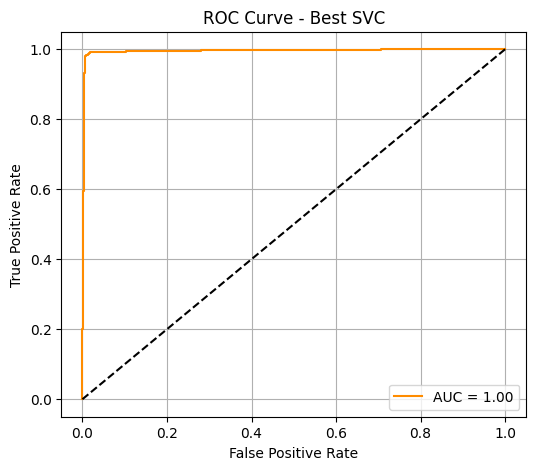

In [ ]:
fpr, tpr, _ = roc_curve(df_label_test, y_prob_best_grid)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_grid:.2f}", color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion matrix

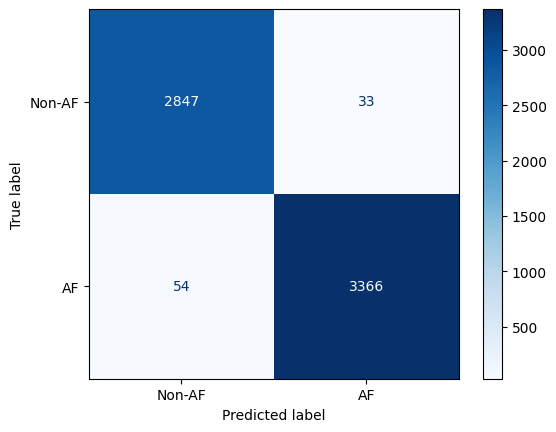

In [ ]:
cm = confusion_matrix(df_label_test, y_pred_best_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF','AF'])
disp.plot(cmap='Blues')
plt.show()

## Hyperparameter Tuning dengan Optuna

### Tuning

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.001, 0.01, 0.1]),
        'degree': trial.suggest_int('degree', 2, 4),  # untuk kernel poly
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 77
    }
    
    # Train model
    svc_optuna = SVC(**param)
    svc_optuna.fit(X_train_xtract, df_label_train)
    
    # Evaluate on validation set
    y_pred_val = svc_optuna.predict(X_val_xtract)
    accuracy = accuracy_score(df_label_val, y_pred_val)
    
    return accuracy

# Create study and optimize
print("Starting Optuna optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=77)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)
print("Optuna optimization Done")

[I 2025-12-03 19:39:08,584] A new study created in memory with name: no-name-f8d16a77-fd57-48ed-bd30-354db9421373


Starting Optuna optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-03 19:39:18,051] Trial 0 finished with value: 0.9814285714285714 and parameters: {'C': 47.47184677446414, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9814285714285714.
[I 2025-12-03 19:39:18,972] Trial 1 finished with value: 0.9815873015873016 and parameters: {'C': 2.25904337744176, 'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9815873015873016.
[I 2025-12-03 19:39:23,601] Trial 2 finished with value: 0.9806349206349206 and parameters: {'C': 0.017992275660414364, 'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 3, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9815873015873016.
[I 2025-12-03 19:39:24,407] Trial 3 finished with value: 0.9822222222222222 and parameters: {'C': 0.3489913256264903, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': None}. Best is trial 3 with value: 0.9822222222222222.
[I 2025-12-03 19:39:25,285]

In [ ]:
best_params_optuna = study.best_params
best_score = study.best_value

print(best_params_optuna)
print(best_score)

{'C': 0.3489913256264903, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': None}
0.9822222222222222


### Run Model

In [ ]:
model_optuna = SVC(**best_params_optuna)
model_optuna.fit(X_train_xtract, df_label_train)

,C,0.3489913256264903
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### Save Model

In [ ]:
# Save trained SVM model
os.makedirs('models/SVM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/SVM/svm_optuna_ppg_ecg_resp_{timestamp}.h5'
model_optuna.save(model_path)
print(f'SVM model saved as: {model_path}')

In [ ]:
y_prob_optuna = model_optuna.decision_function(X_test_xtract)
y_pred_optuna = model_optuna.predict(X_test_xtract)
y_prob_optuna

array([ 3.22727971,  2.40864891, -2.02441353, ..., -1.25674477,
        1.58201733,  2.16383038], shape=(6300,))

## Evaluasi Model Optuna

### Metrik Evaluasi

In [ ]:
acc_optuna = accuracy_score(df_label_test, y_pred_optuna)
prec_optuna = precision_score(df_label_test, y_pred_optuna)
recall_optuna = recall_score(df_label_test, y_pred_optuna)
f1_optuna = f1_score(df_label_test, y_pred_optuna)
rocauc_optuna = roc_auc_score(df_label_test, y_prob_optuna)
print('SVC Evaluation (raw)')
print(f'Accuracy: {acc_optuna:.4f}')
print(f'Precision: {prec_optuna:.4f}')
print(f'Recall   : {recall_optuna:.4f}')
print(f'F1 Score : {f1_optuna:.4f}')
print(f'ROC AUC  : {rocauc_optuna:.4f}')

print(classification_report(df_label_test, y_pred_optuna))


SVC Evaluation (raw)
Accuracy: 0.9860
Precision: 0.9897
Recall   : 0.9845
F1 Score : 0.9871
ROC AUC  : 0.9961
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2880
           1       0.99      0.98      0.99      3420

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



### ROC Curve

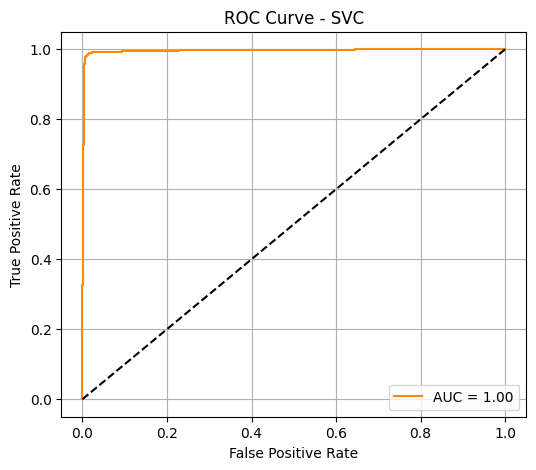

In [ ]:
# ROC curve for raw SVC
fpr, tpr, _ = roc_curve(df_label_test, y_prob_optuna)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_optuna:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix

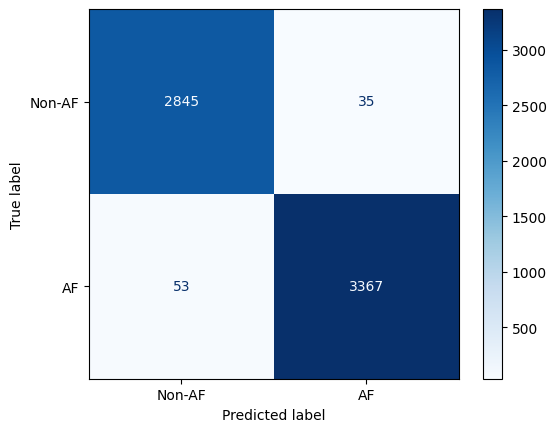

In [ ]:
# Confusion matrix hybrid
cm = confusion_matrix(df_label_test, y_pred_optuna)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

## Tanpa Hyperparameter Tuning

### Run Model

In [ ]:
model_raw = SVC()

model_raw.fit(X_train_xtract, df_label_train)
model_raw

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### Save Model

In [ ]:
# Save trained SVM model
os.makedirs('models/SVM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/SVM/svm_raw_ppg_ecg_resp_{timestamp}.h5'
model_raw.save(model_path)
print(f'SVM model saved as: {model_path}')

In [ ]:
y_prob_raw = model_raw.decision_function(X_test_xtract)
y_pred_raw = model_raw.predict(X_test_xtract)
y_prob_raw

array([ 1.05684708,  1.09972779, -1.03117301, ..., -1.0880427 ,
        1.07544304,  1.2337493 ], shape=(6300,))

## Evaluasi Model Tanpa Hyperparamater Tuning

### Metrik Evaluasi

In [ ]:
acc_raw = accuracy_score(df_label_test, y_pred_raw)
prec_raw = precision_score(df_label_test, y_pred_raw)
recall_raw = recall_score(df_label_test, y_pred_raw)
f1_raw = f1_score(df_label_test, y_pred_raw)
rocauc_raw = roc_auc_score(df_label_test, y_prob_raw)

print('SVC Evaluation (raw)')
print(f'Accuracy: {acc_raw:.4f}')
print(f'Precision: {prec_raw:.4f}')
print(f'Recall   : {recall_raw:.4f}')
print(f'F1 Score : {f1_raw:.4f}')
print(f'ROC AUC  : {rocauc_raw:.4f}')

print(classification_report(df_label_test, y_pred_raw))


SVC Evaluation (raw)
Accuracy: 0.9857
Precision: 0.9891
Recall   : 0.9845
F1 Score : 0.9868
ROC AUC  : 0.9904
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2880
           1       0.99      0.98      0.99      3420

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



### ROC Curve

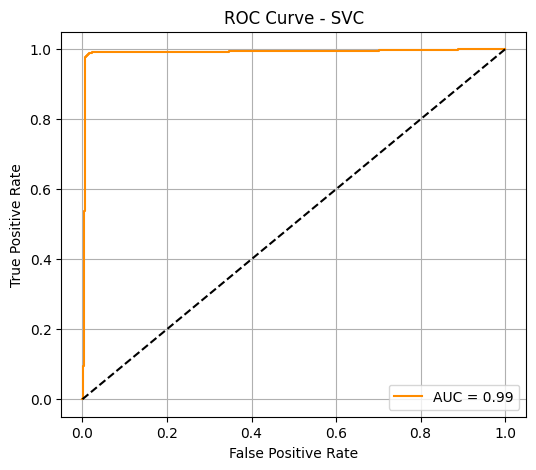

In [ ]:
# ROC curve for raw SVC
fpr, tpr, _ = roc_curve(df_label_test, y_prob_raw)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_raw:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix

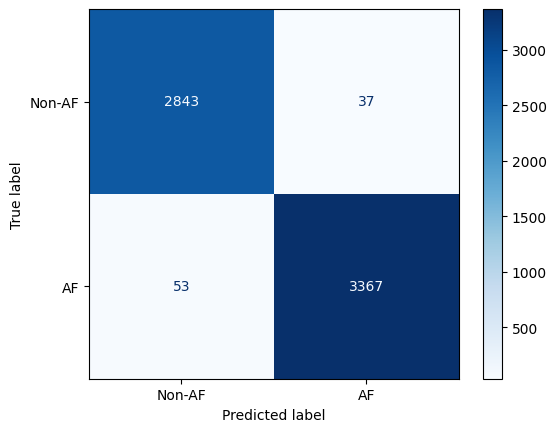

In [ ]:
# Confusion matrix hybrid
cm = confusion_matrix(df_label_test, y_pred_raw)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

# Evaluasi

## Histogram Perbandingan Accuracy

In [ ]:
try:
    acc_dict = {
        'GridSearchCV': acc_grid,
        'Optuna': acc_optuna,
        'No Tuning': acc_raw
    }
except NameError:
    acc_dict = {}
    if 'y_pred_best_grid' in globals():
        acc_dict['GridSearchCV'] = accuracy_score(df_label_test, y_pred_best_grid)
    if 'y_pred_optuna' in globals():
        acc_dict['Optuna'] = accuracy_score(df_label_test, y_pred_optuna)
    if 'y_pred_raw' in globals():
        acc_dict['No Tuning'] = accuracy_score(df_label_test, y_pred_raw)

if not acc_dict:
    raise RuntimeError("Accuracies not available. Jalankan cell evaluasi model terlebih dahulu.")

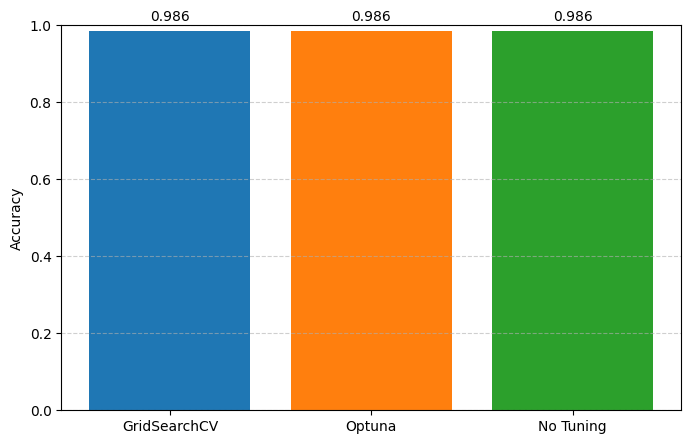

In [ ]:
# Plot
acc_series = pd.Series(acc_dict)
acc_series = acc_series.reindex(['GridSearchCV', 'Optuna', 'No Tuning'])  # konsisten urutan

plt.figure(figsize=(8,5))
bars = plt.bar(acc_series.index, acc_series.values, color=['C0','C1','C2'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

## Histogram Perbandingan Recall

In [ ]:
try:
    rec_dict = {
        'GridSearchCV': rec_grid,
        'Optuna': recall_optuna,
        'No Tuning': recall_raw
    }
except NameError:
    rec_dict = {}
    if 'y_pred_best_grid' in globals():
        rec_dict['GridSearchCV'] = recall_score(df_label_test, y_pred_best_grid)
    if 'y_pred_optuna' in globals():
        rec_dict['Optuna'] = recall_score(df_label_test, y_pred_optuna)
    if 'y_pred_raw' in globals():
        rec_dict['No Tuning'] = recall_score(df_label_test, y_pred_raw)

if not rec_dict:
    raise RuntimeError("Recalls not available. Jalankan cell evaluasi model terlebih dahulu.")

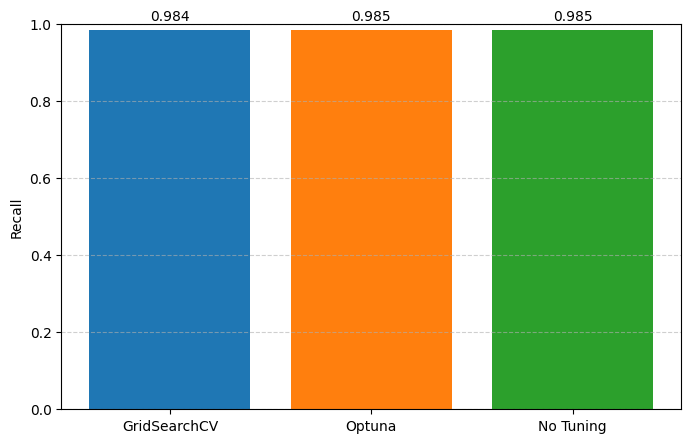

In [ ]:
# Plot
rec_series = pd.Series(rec_dict)
rec_series = rec_series.reindex(['GridSearchCV', 'Optuna', 'No Tuning'])  # konsisten urutan

plt.figure(figsize=(8,5))
bars = plt.bar(rec_series.index, rec_series.values, color=['C0','C1','C2'])
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

# SAVE ALL

In [ ]:
# # Target directory
# os.makedirs('model_deploy', exist_ok=True)
# timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# # Preprocessing pipeline: MinMaxScaler, PCA, ReshapeTransformer (pkl)
# # path_prep = f'model_deploy/{timestamp}_preprocess.pkl'
# # joblib.dump(preprocess_pipeline, path_prep)
# # print("1. Preprocessing pipeline successfully saved.")

# # Reshaper for input LSTM (pkl)
# path_reshaper = f'model_deploy/{timestamp}_reshaper.pkl'
# joblib.dump(reshape_pipeline, path_reshaper)
# print("1. Reshaper has been successfully saved.")

# # LSTM Model for feature extraction (h5)
# path_lstx = f'model_deploy/{timestamp}_lstmx.h5'
# lstm_last_dense.save(path_lstx)
# print("2. LSTMX pipeline successfully saved.")

# # Hybrid LSTM-XGBoost (json)
# path_hybrid = f'model_deploy/{timestamp}_hybrid_lxgb.json'
# best_hybrid.save_model(path_hybrid)
# print("3. Hybrid model successfully saved.")

<!-- # Contoh cara pake buat prediksi -->

In [ ]:
# # --- Load semua komponen ---
# loaded_preprocessor = joblib.load(path_prep)
# loaded_feature_extractor = tf.keras.models.load_model(path_lstx)
# loaded_xgb_model = XGBClassifier()
# loaded_xgb_model.load_model(path_hybrid)


# # --- Buat fungsi prediksi end-to-end ---
# def predict_hybrid_system(data_mentah):
#     """
#     Fungsi ini menjalankan data mentah melalui seluruh alur hybrid.
#     """
#     # Pastikan input adalah 2D
#     if data_mentah.ndim == 1:
#         data_mentah = data_mentah.reshape(1, -1)
        
#     # 1. Jalankan preprocessing
#     data_processed = loaded_preprocessor.transform(data_mentah)
    
#     # 2. Ekstrak fitur dengan LSTM
#     fitur_lstm = loaded_feature_extractor.predict(data_processed)
    
#     # 3. Lakukan prediksi akhir dengan XGBoost
#     prediksi_final = loaded_xgb_model.predict(fitur_lstm)
#     probabilitas = loaded_xgb_model.predict_proba(fitur_lstm)
    
#     return prediksi_final[0], probabilitas[0]


# # --- Uji coba pada satu sampel data mentah ---
# # Ambil satu sampel dari X_test MENTAH (sebelum diproses)
# contoh_data = X_test_mentah[0] 

# hasil, prob = predict_hybrid_system(contoh_data)

# print(f"\n--- Hasil Prediksi pada Data Baru ---")
# print(f"Prediksi Kelas: {hasil} (0=Non-AF, 1=AF)")
# print(f"Probabilitas [Non-AF, AF]: [{prob[0]:.4f}, {prob[1]:.4f}]")